# Project 6b: Scattering
## Authored by candidates 15908 & 15907

#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended python imports to solve the exercises.

In [ ]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

Imports

In [2]:
%matplotlib inline
import matplotlib as mpl

import inspect
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from astropy import units
from astropy import units as u, constants as c
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats, HTML, display
from cycler import cycler
from numba import jit
from numpy import random, newaxis as nax
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

quantity_support()
set_matplotlib_formats('svg')
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('legend', frameon=False)

Integrals to get intensity.

In [3]:
from numba import jit 
from math import exp

@jit(nopython=True)
def iplus(tau, source_function, mu):
    """
    Calculates I+ for a given tau and source function, at all depth points
    """
    ndep = len(source_function)
    intensity = np.zeros(ndep)
    for i in range(ndep):
        i_upw = source_function[-1]
        ibot = i - len(tau)
        for j in range(-1, ibot, -1):
            expdtau = exp(-(tau[j] - tau[j - 1]) / mu)
            i_upw = i_upw * expdtau + source_function[j] * (1 - expdtau)
        intensity[i] = i_upw
    return intensity


@jit(nopython=True)
def iminus(tau, source_function, mu):
    """
    Calculates I- for a given tau and source function, at all depth points
    """
    ndep = len(source_function)
    intensity = np.zeros(ndep)
    for i in range(ndep):
        i_upw = 0.
        for j in range(i):
            expdtau = exp((tau[j] - tau[j + 1]) / mu)
            i_upw = i_upw * expdtau + source_function[j] * (1 - expdtau)
        intensity[i] = i_upw 
    return intensity

Reading units from falc table.

In [4]:
i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

falc = read_table_units("falc.dat")
# Loading the data into separate variables:
height        = falc["height"]               # Height above tau_500 = 1
tau_500       = falc["tau_500"]              # Radial optical depth
temp          = falc["temperature"]          # Temperature
n_e           = falc["electron_density"]     # Electron density
n_p           = falc["proton_density"]       # Proton density (ionised Hydrogen)
total_n_h     = falc["hydrogen_density"]     # Total density of Hydrogen (includes both neutral and ionised)
n_h = total_n_h - n_p                        # Number density of neutral hydrogen

Function to compute $H^-$ cross section.

In [5]:
def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * u.K / temp
    electron_pressure = electron_density[..., nax] * c.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1e-22 * u.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * u.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * u.cm ** 2 / u.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf = kappa_bf * (1 - np.exp(-c.h * c.c / (wave * c.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]], dtype="object")
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp)
    kappa_ff *= 1e-26 * (u.cm ** 4) / u.dyn
    return (kappa_bf + kappa_ff).si

---

### Exercise 1: Pure scattering

We consider a homogeneous slab in 3D space where there is no absorption and photons only interact with the medium through scattering. This means that $\alpha_\nu^a = 0$ such that $\varepsilon_\nu = 0$.



<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
  <img style="float: right;" src="images/mfp.svg" width=50px>
    
* Use a Monte Carlo random walk calculation to show that the total path length traveled after N scatterings is $l^* \approx \sqrt{N} l$.

We advance a photon by one mean free path and scatter it in a random direction. This is done by assigning two random angles $\varphi \in [0, 2\pi)$ and $\theta \in [0,\pi)$ from uniform distributions. This Monte Carlo simulation is implemented in the function `scatter`.

In [6]:
@jit(nopython=True)
def scatter(n_scatterings, mean_free_path):
    """
    Monte Carlo Simulation of photons going through a scattering medium.
    Returns position of photons at all points.
    n_scatterings: number of scatterings photon is subject to
    mean_free_path: path a photon travels between scatterings
    """
    phi = random.uniform(0, 2*np.pi, n_scatterings)
    theta = random.uniform(0, np.pi, n_scatterings)
    x = mean_free_path*np.sin(theta)*np.cos(phi)
    y = mean_free_path*np.sin(theta)*np.sin(phi)
    z = mean_free_path*np.cos(theta)
    
    xpos = np.cumsum(x)
    ypos = np.cumsum(y)
    zpos = np.cumsum(z)
    
    return xpos, ypos, zpos

We perfrom $10^3$ Monte Carlo simulations, analogous to simulating $10^3$ photons. Each photon is subject to $N$ scatterings. We find the mean value from all Monte Carlo simulations at different of numbers of scatterings $N$, and compare with $l^* \approx \sqrt{N} l$. Here, we use a mean free path of $l = 2$.

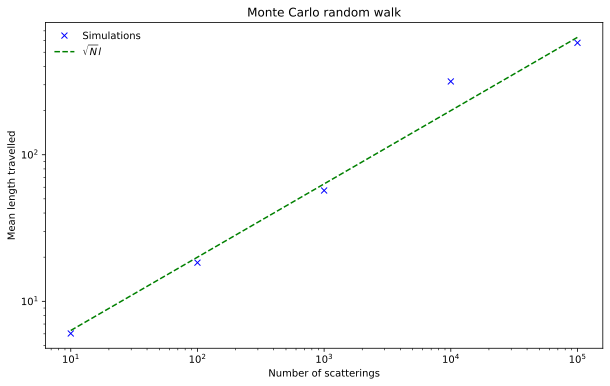

In [7]:
N = 10**5                       #Number of scatterings
l = 2                           #Mean free path
n_MC = 10**3                    #Number of Monte Carlo simulations
l_star = np.zeros((5, n_MC))    #Length a photon travels in each Monte Carlo simulation

random.seed(1)
for i in range(n_MC):
    x, y, z = scatter(N, l)
    l_star[0,i] = np.linalg.norm((x[10] - x[0], y[10] - y[0], z[10] - z[0]))
    l_star[1,i] = np.linalg.norm((x[10**2] - x[0], y[10**2] - y[0], z[10**2] - z[0]))
    l_star[2,i] = np.linalg.norm((x[10**3] - x[0], y[10**3] - y[0], z[10**3] - z[0]))
    l_star[3,i] = np.linalg.norm((x[10**4] - x[0], y[-1] - y[0], z[10**4] - z[0]))
    l_star[4,i] = np.linalg.norm((x[10**5-1] - x[0], y[10**5-1] - y[0], z[10**5-1] - z[0]))

mean_length = np.mean(l_star, axis=1)

N_list = [10, 10**2, 10**3, 10**4, 10**5-1]
mean_expected = l*np.sqrt(N_list)
    
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(N_list, mean_length, 'bx', label="Simulations")
ax.loglog(N_list, mean_expected, "g--", label=r"$\sqrt{N}l$")
ax.set_title("Monte Carlo random walk")
ax.set_xlabel("Number of scatterings")
ax.set_ylabel("Mean length travelled")
ax.legend();

Here we see the average path travelled by photons from 1000 Monte Carlo simulations and the expected path travelled $l^* = \sqrt{N}l$. There is a good accordance between the two. If we increase the number of Monte Carlo simulations, the Monte Carlo simulation should converge to the expected value $l^*$. We plot a Monte Carlo simulation in 3D to visualise a photons path.

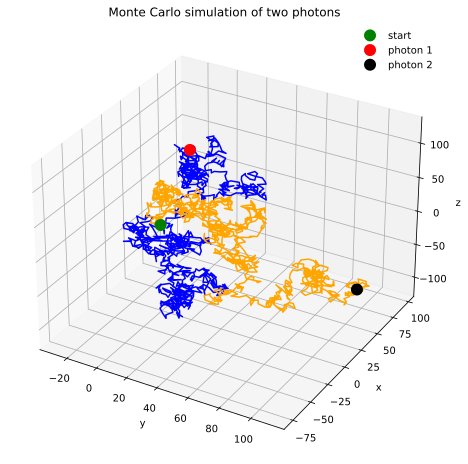

In [8]:
from mpl_toolkits.mplot3d import Axes3D

random.seed(1)
x1, y1, z1 = scatter(10**3, 5)
x2, y2, z2 = scatter(10**3, 5)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(x1, y1, z1, marker='.', ms=0.1)
ax.plot(x2, y2, z2, marker='.', ms=0.1, color = "orange")
ax.plot([0.], [0.], [0.], 'go', ms=10, mew=2, label='start')
ax.plot(x1[-1], y1[-1], z1[-1], 'ro', ms=10, mew=2, label='photon 1')
ax.plot(x2[-1], y2[-1], z2[-1], 'ko', ms=10, mew=2, label='photon 2')
ax.set_xlabel("y")
ax.set_ylabel("x")
ax.set_zlabel("z")
ax.set_title("Monte Carlo simulation of two photons")
ax.legend();

This simulation shows two different photons (blue and yellow). The photon plotted in yellow travels far, while the photon plotted in blue travels short. This illustrates that the approximation $l_* = \sqrt{N}l$ only holds for the average of very many photons. (Note: this was true on the laptop of the author. The random seed will most likely change from computer to computer, which can affect how far the photons travel.)

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
* For an optically thick slab of thickness D, the total number of scattering before the photon escape is $N \approx \tau^2$. Show this:
    1. Analytically
    2. Using a Monte Carlo simulation

*Hint: Plot the simulated values for different extinction values.* 
</div>

For a random walk, the net displacement of a photon is 
$$
\vec{R} = \vec{r}_1 + \vec{r}_2 + \dots + \vec{r}_N\,.
$$
To find the distance traveled by a typical photon, we have to find $\left \langle \vec{R}^2 \right \rangle$, because the mean displacement is zero. We find
$$
l_*^2 = \left \langle \vec{R}^2 \right \rangle = \left \langle \vec{r}_1^2 \right \rangle + \left \langle \vec{r}_2^2 \right \rangle + \left \langle \vec{r}_N^2 \right \rangle + \dots + 2\left \langle \vec{r}_1\cdot\vec{r}_2 \right \rangle + 2\left \langle \vec{r}_1\cdot\vec{r}_2 \right \rangle + \dots\,.
$$

Each term involving the square of a displacement averages to the mean square of the free path of a photon, and the cross terms vanish for isotropic scattering. Therefore,
$$
l_*^2 \approx Nl^2 \Rightarrow N \approx \frac{l_*^2}{l^2}\,.
$$
The number of scatterings required for a photon to escape the optically thick medium is determined by $l_* \approx D$. Since $l$ is the mean free path, $\tau \approx D/l$. Therefore the number of scatterings a photon has before escaping the medium is 
$$
N \approx \tau^2\,.
$$
We can show this through a Monte Carlo simulation. We simulate a number of photons, and record the photons that escape the meduim after $N = (D/l)^2$ scatterings. We still use $l = 2$, and $D = 10$.

In [9]:
escaped = 0                #Number of photons escaping medium
D = 10                     #Size of medium
N = int(D/l)**2            #Number of scatterings

random.seed(2)
for i in range(n_MC):
    x, y, z = scatter(N, l)
    if np.linalg.norm((x[-1] - x[0], y[-1] - y[0], z[-1] - z[0])) >= D:
        escaped += 1

mean_length = np.mean(l_star)
N_l = np.sqrt(N)*l
display(HTML(r"$N \approx \tau^2 = %d$" %((D/l)**2)))
display(HTML(r"Fraction of photons escaped after N scatterings: %.1f" %(escaped/n_MC)))

In this simulation, $40\%$ of photons escaped the medium. This is not far from the majority of all photons escaping the medium, which means the approximation $N \approx \tau^2$ is not far from being true.

---- 
### Exercise 2: Diffusion by scattering

We consider a rectangular box with height $D$ containing a medium with extinction $\alpha^a$ and $\alpha^s$ from absorption and scattering processes respectively. At the bottom of the box, photons are emitted vertically only from specific locations. The locations where photons are emitted are given by a mask saved in the file `RoCS_array.npy`, which contains an integer array. We emit photons in the vertical direction in locations where this array is non-zero. We assume the physical size of each pixel is 1 m x 1 m. 

Since the extinction $\varepsilon_\nu = \alpha_\nu^a/(\alpha_\nu^a + \alpha_\nu^s)$ is the probability for a photon to become extinct, we can set up a Monte Carlo simulation to study scattering and absorption in the medium. We compare a random number $p$ between $[0,1]$ with $\varepsilon_\nu$, and extinct the photon if $p < \varepsilon_\nu$. If $p > \varepsilon_\nu$, the photon is scattered. Then we advance the photon a length $l = \tau_i/\alpha_\nu^\textrm{tot}$ in a random direction. The optical depth we advance the photon is given by $\tau_i = -\ln \xi$ where $\xi$ is a random number in $[0,1]$.

We end the simulation when a photon is destroyed or if it exits the box. If it exits the box in the top, we record its position and denote is as a "hit". This is implemented in the following `python` functions `diffusion` and `RoCS`.

In [10]:
data = np.load("RoCS_array.npy")
@jit(nopython = True)
def diffusion(y, x, eps, alpha_tot, D, z=0):
    """
    Monte Carlo Simulation of photons going through a medium.
    Returns position of photon if it escapes.
    eps: extinction coefficient
    alpha_tot: total absorption
    x, y, z: initital position of photon
    D = optical depth of medium, can be thought of as height of box
    """
    hit = 1
    phi = 0       #Doesn't matter what phi is in the first iteration
    theta = 0     #Photons emitted vertically
    while z < D:
        prob = random.uniform(0, 1)
        chi = random.uniform(0, 1)
        tau = -np.log(chi)
        l = tau/alpha_tot
        x += l*np.sin(theta)*np.cos(phi)
        y += l*np.sin(theta)*np.sin(phi)
        z += l*np.cos(theta)
        
        if x < 0 or  y < 0 or z < 0 or y > data.shape[0] or x > data.shape[1]:       #Photon exits box
            hit = 0
            break
        
        elif eps > prob:  #absorption!
            hit = 0
            break
            
        else:             #scattering!
            #Assign random direction for photon
            phi = random.uniform(0, 2*np.pi) 
            theta = random.uniform(0, np.pi)
            continue
            
    return int(y), int(x), hit

@jit(nopython=True)
def RoCS(alpha_a, alpha_s, D, n_phot=5):
    """
    Calculates how the RoCS picture looks like through a medium
    alpha_a: absorption coefficient
    alpha_s: scattering coefficient
    D: height of box
    """ 
    eps = alpha_a/(alpha_a + alpha_s)
    alpha_tot = alpha_a + alpha_s
    diffuse = np.zeros(data.shape)
    for j in range(data.shape[0]):
        for i in range(data.shape[1]):
            for k in range(n_phot):
                if data[j, i] != 0:
                    y, x, hit = diffusion(j, i, eps, alpha_tot, D)
                    if y < data.shape[0] and x < data.shape[1]:
                        diffuse[y, x] += hit
    return diffuse

We test the code with different parameters. We let the height of the box $D = 20$ for all our experiments. For each experiment, we set a random seed to reduce bias. To reduce noise, we emit several photons from each pixel. First, we let $\alpha^s = 1$ be constant and vary $\alpha^a$.

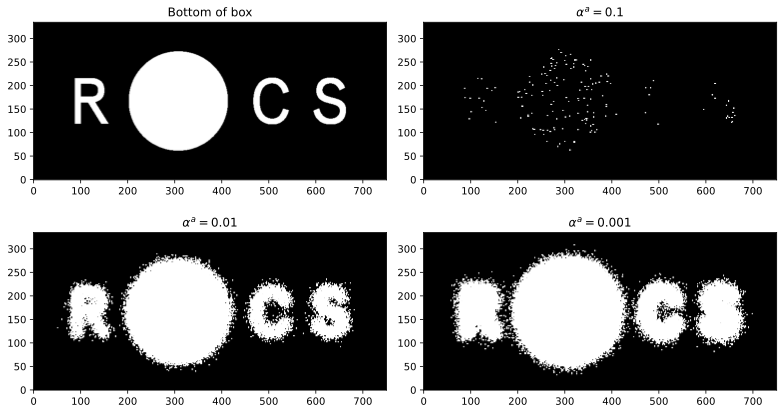

In [11]:
random.seed(1)
rocs_pic1 = RoCS(0.1, 1, D=20, n_phot = 50)
random.seed(1)
rocs_pic2 = RoCS(0.01, 1, D=20, n_phot = 50)
random.seed(1)
rocs_pic3 = RoCS(0.001, 1, D=20, n_phot = 50)

fig, ax = plt.subplots(2, 2, figsize=(11,6))
ax[0,0].set_title(r"Bottom of box")
ax[0,0].imshow(data/255, origin='lower', cmap=plt.get_cmap('gist_gray'))
ax[0,1].set_title(r"$\alpha^a = 0.1$")
ax[0,1].imshow(rocs_pic1, origin='lower', vmin=0, vmax=0.1, cmap=plt.get_cmap('binary_r'))
ax[1,0].set_title(r"$\alpha^a = 0.01$")
ax[1,0].imshow(rocs_pic2, origin='lower', vmin=0, vmax=0.1, cmap=plt.get_cmap('binary_r'))
ax[1,1].set_title(r"$\alpha^a = 0.001$")
ax[1,1].imshow(rocs_pic3, origin='lower', vmin=0, vmax=0.1, cmap=plt.get_cmap('binary_r'))
fig.tight_layout();

When $\alpha^a = 0.1$, almost no light reaches through. We only see some random dots, with little information of the original picture. We make out the O, but the intensity is significantly reduced. The other letters are impossible to make out. When $\alpha^a$ decreases, more and more photons make it to the top of the box. We see that the photons are scattered, making the letters smudged. Of the 100 photons we initially emitted when $\alpha^a = 0.001$, we check the maximum number of hits in one pixel.

In [12]:
display(HTML("Max number of photon hits: %d." %rocs_pic3.max()))

This means that the intensity is reduced through the medium, with about 25% of photons passing through. When we have a high scattering coefficient, the photons will interact very many times. Therefore, even though the absorption coefficient is very low, there is a large probability the photon is extinct. This is seen from the max number of photon hits in the simulation of the bottom right panel where number of photons is significantly reduced even though the absorption coefficient is low.

Next, we let $\alpha^s$  vary while we hold $\alpha^a = 10^{-4}$ constant. In the previous case, we did not set intensity of the pixels according to number of hits. Therefore we did not see how the actual picture would look like through the medium. Now we will scale intensity according to number of photons emitted from the bottom. We amplify the intensity at the top to get a clearer view of the details.

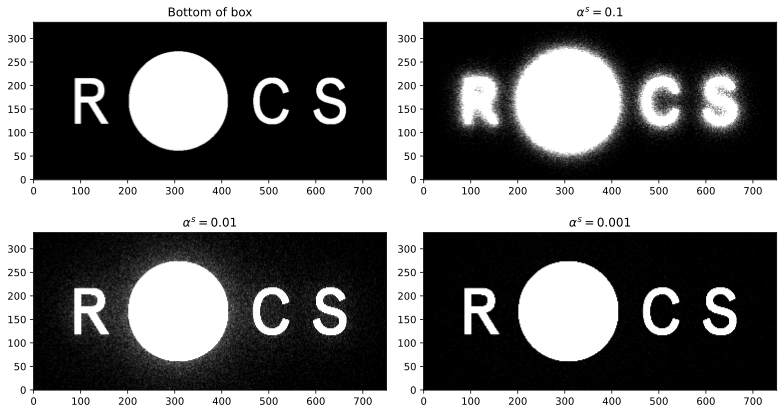

In [13]:
random.seed(1)
rocs_pic4 = RoCS(1e-4, 0.1, D=20, n_phot = 50)
random.seed(1)
rocs_pic5 = RoCS(1e-4, 0.01, D=20, n_phot = 50)
random.seed(1)
rocs_pic6 = RoCS(1e-4, 0.001, D=20, n_phot = 50)

fig, ax = plt.subplots(2, 2, figsize=(11,6))
ax[0,0].set_title(r"Bottom of box")
ax[0,0].imshow(data/255, origin='lower', cmap=plt.get_cmap('gist_gray'))
ax[0,1].set_title(r"$\alpha^s = 0.1$")
ax[0,1].imshow(rocs_pic4, origin='lower', vmin=0, vmax=5, cmap=plt.get_cmap('binary_r'))
ax[1,0].set_title(r"$\alpha^s = 0.01$")
ax[1,0].imshow(rocs_pic5, origin='lower', vmin=0, vmax=5, cmap=plt.get_cmap('binary_r'))
ax[1,1].set_title(r"$\alpha^s = 0.001$")
ax[1,1].imshow(rocs_pic6, origin='lower', vmin=0, vmax=5, cmap=plt.get_cmap('binary_r'))
fig.tight_layout();

Here we see that as the scattering coefficient gets lower, more and more of the original photo reaches the top. We can investigate the relative difference in photon extinction between the different cases. This is done by averaging photon hits over the entire area.

In [14]:
display(HTML(r"Average number of photon hits. $\alpha^s = 0.1: %d, \alpha^s = 0.01: %d, \alpha^s = 000.1: %d$."
             %(rocs_pic4.mean(), rocs_pic5.mean(), rocs_pic6.mean())))

We can also investigate how much of the photons that went through the medium with $\alpha^s = 0.001$ and $\alpha^a = 10^{-4}$.

In [15]:
display(HTML(r"Number of photon hits per photon emitted: %f."
             %(rocs_pic6.sum()/(data.sum()/255*50))))

Thus we get a qualitive insight into the absorption for each case. We see that for $\alpha^s = 0.1$, the absorption is high relative to the other cases. Even though the absorption coefficient was the same for all cases, the photons passing through the medium with highest scattering coefficient were subject to many more interactions. Therefore they had a higher probability of being extinct, or escaping the box. The absorption seems to stabilise when the scattering coefficient is 0.01 or smaller. Here, $\sim 90\%$ of the photons pass through the medium.

The mean free path is found by
$$
l = \frac{\left \langle \tau \right \rangle}{\alpha^\textrm{tot}} = \frac{1}{\alpha^{tot}}
$$
We now wish to investigate how many mean free paths the structures at the bottom need to be to be visible at the top. We increase the height of the box, set a high scattering coefficient, and set absorption to zero. We plot photon hits, and find a case where the circle is visible and the letters are not. For the following case, $D = 100$, $\alpha^s = 1$, and $\alpha^a$ = 0. We simulate 10 photons per pixel.

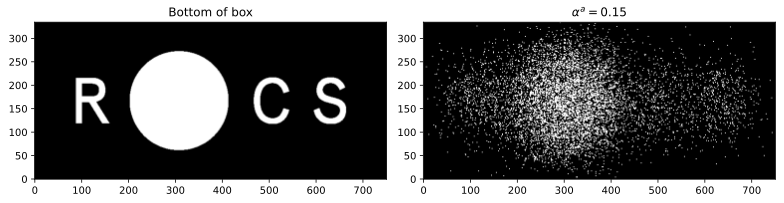

In [16]:
random.seed(1)
rocs_pic7 = RoCS(0, 1, D=100, n_phot = 10)
fig, ax = plt.subplots(1, 2, figsize=(11,6))
ax[0].set_title(r"Bottom of box")
ax[0].imshow(data/255, origin='lower', cmap=plt.get_cmap('gist_gray'))
ax[1].set_title(r"$\alpha^a = 0.15$")
ax[1].imshow(rocs_pic7, origin='lower', vmin=0, vmax=0.25,
             cmap=plt.get_cmap('binary_r'))
fig.tight_layout();

In the right panel, the letters have dissappeared. The circle is barely visible. In this case the mean free path is $l = 1$. The letters are approximately 25 in width, or $25 l$. The circle (approximately 200 in diameter) is still visible. This structure is 200 mean free paths in size. This means that the structures in this case need to be approximately 200 mean free paths in size to be visible at the top.

----

### Exercise 3: Optically thick radiative transfer with scattering

In LTE, radiation and matter are coupled, meaning that radiative excitations always get collisionally de-excited. This does not account for a key process in the solar atmosphere, namely scattering. Now, we wish to go beyond the LTE appoximation to calculate radiation with scattering from the falc solar model atmosphere.

We calculate radiation from the wavelength 500 nm, with corresponding optical depth $\tau_{500}$ from the falc model. We will assume the photon destruction probability $\varepsilon_\nu$ to be constant throughout the atmosphere. We use the ratio between line optical depth and the continuum optical depth
$$
\eta_\nu \equiv \frac{\tau_\nu^l}{\tau_\nu^c},
$$
so that the total optical depth can be written as:
$$
\tau_\nu^\mathrm{total} = \tau_\nu^c (1 + \eta_\nu).
$$

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

*Hints:*
* *The simple lambda iteration method struggles for $\varepsilon_\nu \ll 1$. Do not run for $\varepsilon_\nu < 10^{-3}$.*
* *You can check if your solution is physical by noting that in the interior of the star, TE holds, so $J_\nu = S_\nu = B_\nu$. If this stops being the case, you have some numerical errors.*
* *If you use the original FALC depth grid with 80 depth points, lambda iteration will start failing around $\varepsilon_\nu < 10^{-1}$. This can be mitigated by using a higher resolution optical depth grid, for example by interpolating the FALC values to a finer grid. The lower the $\varepsilon_\nu$, the more depth points you will need to avoid numerical errors.*
 
</div>

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Write a simple lambda iteration solver that computes $J_\nu$ and $S_\nu$ for the single wavelength of 500 nm as a function of $\tau_\nu^c$, $B_\nu$, $\eta_\nu$, and $\varepsilon_\nu$. You can obtain $B_\nu$ by using the temperatures in a model atmosphere.
 
</div>

In [17]:
def J_nu(S, tau_tot):
    # Three-point Gaussian integration intensity -> flux
    # rescale mu range from [-1, 1] to [0, 1]
    mu_gauss = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)]) / 2 + 0.5  
    weight_gauss = (np.array([5/9, 8/9, 5/9]) / 2)
    J = 0
    for mu, weight in zip(mu_gauss, weight_gauss):
        J += weight/2*(iplus(tau_tot, S, mu) + iminus(tau_tot, S, mu))
    return J*S.unit
        
def lambda_iteration(tau_c, B_nu, eta_nu, eps_nu, tol=1e-3):
    tau_tot = tau_c*(1 + eta_nu)
    S_old = B_nu
    S_new = (1-eps_nu)*J_nu(S_old, tau_tot) + eps_nu*B_nu
    counter = 0
    while np.linalg.norm((S_new - S_old)/S_old) > tol and counter < 2000:
        S_old = S_new
        S_new = (1-eps_nu)*J_nu(S_old, tau_tot) + eps_nu*B_nu
        counter += 1
    
    return S_new, J_nu(S_new, tau_tot)

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Using your solver, compute $J_\nu$ and $S_\nu$ for the FALC model atmosphere. Run for $\varepsilon_\nu = [0.5, 10^{-2}, 10^{-3}]$, and $\eta_\nu= [10^2, 10^4, 10^6]$ and for each of the nine combinations plot $J_\nu$, $S_\nu$, and $B_\nu$ vs $\tau_\nu^c$. 
    
</div>

In [18]:
def Falc_interpolater(length, x = "height", QL = ["tau_500", "temperature"]):
    exec("global %s_new; %s_new = np.linspace(falc[x][0], falc[x][-1], length)"%(x, x))
    for i in range(len(QL)):
        if type(QL[i]) == str:
            exec("global %s_new; %s_new = interp1d(falc['%s'], falc['%s'])(%s_new)"%(QL[i], QL[i], x, QL[i], x))
        else:
            exec("global %s_new; %s_new = interp1d(falc['%s'], QL[i][1])(%s_new)"%(QL[i][0], QL[i][0], x, x))

In [19]:
Falc_interpolater(int(3e3), QL = ["tau_500", "temperature"])

B = BlackBody(temperature_new * u.K, scale = 1 * u.Unit(i_units))(500 * u.nm)
eps_list = [0.5, 1e-2, 1e-3]
eta_list = [1e2, 1e4, 1e6]

#S = []
#J = []
#for eps in eps_list:
#    for eta in eta_list:
#        S_, J_ = lambda_iteration(tau_500_new, B, eta, eps)
#        S.append(S_)
#        J.append(J_)

#np.save("lambda_iter.npy", np.array([S, J]))

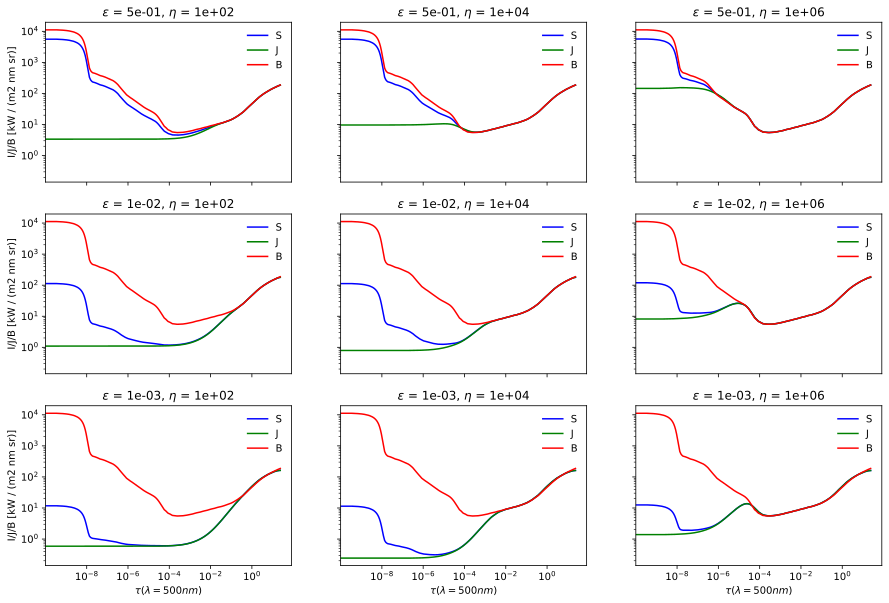

In [20]:
S, J = np.load("lambda_iter.npy") * u.Unit(i_units)

fig, ax = plt.subplots(3, 3, figsize = (15, 10), sharex = True, sharey = True)
for i in range(len(eps_list)):
    for j in range(len(eta_list)):
        ax[i, j].set_title(r"$\epsilon$ = %.0e, $\eta$ = %.0e"%(eps_list[i], eta_list[j]))
        ax[i, j].loglog(tau_500_new, S[i * 3 + j], label="S")
        ax[i, j].loglog(tau_500_new, J[i * 3 + j], label="J")
        ax[i, j].loglog(tau_500_new, B, label = "B")
        ax[i, j].legend()
        ax[-1, j].set_xlabel(r"$\tau(\lambda = 500 nm)$")
    ax[i, 0].set_ylabel(r"I/J/B [%s]"%S[0].unit)
    ax[i, 1].set_ylabel(""); ax[i, 2].set_ylabel("")

plt.show()

Epsilon decreases the source function, S, very much above the surface and also reduces the angle averaged intensity J. An increase in eta also effect both the source function and the angle averaged intensity. J follow the Planck function longer for increased eta, and its development is determined by the curve of the source function. The source function follow the angle averaged intensity for some distance above the surface, determined by eta, and epsilon, where a higher value of eta makes S follow J for longer. Epsilon seem to determine how much eta can vary this points position. After the source function stop following the J, it follows the Planck function's development to a value determined by epsilon. epsilon here increases this point if almost linearly.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Explain what is happening in physical terms. How does $\eta_\nu$ affect the result? And $\varepsilon_\nu$? When is LTE no longer valid? At what point is radiation thermalised ($J_\nu \approx B_\nu$)?
 
</div>

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">


* Scattering makes radiation decouple from the local conditions deeper in the atmosphere that it would otherwise. So the photons that reach the surface are effectively formed in deeper layers. But scattering can greatly reduce the number of photons that reach the surface (e.g. see decrease in $J_\nu$). The more scattering, the fewer photons reaching the surface. Why is that? 
 
 
</div>

Higher scattering increase the time and number of interactions before a photon can escape. This also means that a larger portion is stored inside the star and a smaller amount of radiation reaches the surface, so long as we assume the amount of photons produced isn't effected by the amount of photons inside the star. This is not a hundred percent correct, as the higher radiation pressure will result in a less dens star and lower formation rate, but er påvirkning til stråletrykk på antall fotoner produsert mindre enn hvordan spredning påvirker unslipningstid fra stjerna
Har absorpsjon av fotoner noe å si her? Altså er dette et resultat av at flere fotoner blir absorbert og brukt til sammenslåing av partikler.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
 
* Assuming $\varepsilon_\nu$ is constant with height helps understand scattering, but is a poor approximation. Compute and plot the height-dependent $\varepsilon_\nu$ for the FALC model at 500 nm, using the extinction sources you computed in Project 4 (H$^{-}$ extinction and Thomson scattering). At which height does scattering start to be important?
 
</div>

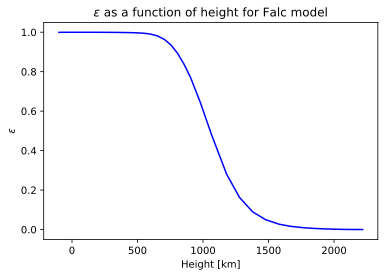

In [21]:
sigma_Hmin = np.concatenate(compute_hminus_cross_section(0.5 * u.um, temp, n_e))
alpha_Hmin = (sigma_Hmin * n_h).to("km-1")         # Extinction due to H- at lambda = 500nm
sigma_T = 6.648e-29 * u.m ** 2
alpha_T = (sigma_T * n_e).to("km-1")           # Extinction due to Thomson scattering
eps = np.array(alpha_Hmin / (alpha_Hmin + alpha_T))

plt.plot(height.to("km"), eps);
plt.title(r"$\epsilon$ as a function of height for Falc model")
plt.xlabel("Height [km]")
plt.ylabel(r"$\epsilon$");

Scattering start to become important around 750 km above the surface. This is where the $\epsilon$ starts to drop of and after about 750 km the scattering dominates and $\epsilon$ is approximately zero.

We can also try to use this new epsilon to calculate the I and J of the Falc model as we did earlier and see what result we get.

In [22]:
Falc_interpolater(int(1e3), QL = ["tau_500", "temperature", ["eps", eps]])

B = BlackBody(temperature_new * u.K, scale = 1 * u.Unit(i_units))(500 * u.nm)

#S = []
#J = []
#for eta in eta_list:
#    S_, J_ = lambda_iteration(tau_500_new, B, eta, eps_new)
#    S.append(S_)
#    J.append(J_)
#np.save("lambda_iter_second.npy", np.array([S, J]))

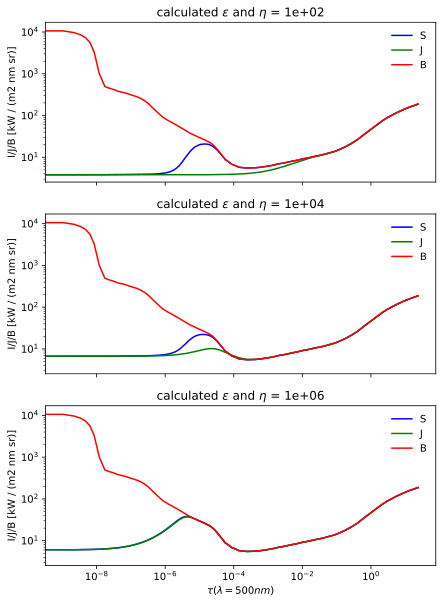

In [23]:
S, J = np.load("lambda_iter_second.npy") * u.Unit(i_units)

fig, ax = plt.subplots(3, figsize = (7, 10), sharex = True, sharey = True)
for i in range(len(eta_list)):
    ax[i].set_title(r"calculated $\epsilon$ and $\eta$ = %.0e"%(eta_list[i]))
    ax[i].loglog(tau_500_new, S[i], label="S")
    ax[i].loglog(tau_500_new, J[i], label="J")
    ax[i].loglog(tau_500_new, B, label = "B")
    ax[i].legend()
    ax[i].set_ylabel(r"I/J/B [%s]"%S[0].unit)
ax[-1].set_xlabel(r"$\tau(\lambda = 500 nm)$");